In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

base_dir = os.path.abspath("..")
sys.path.append(base_dir)

from utils.analyze_lensing import make_lensing_dataframe, \
    integrated_event_duration_posterior, t_of_tau, count_events_per_source, \
    count_filter_seq

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
fig_dir = os.path.join(base_dir, "plots/2sep2024_MC/")
results_dir = os.path.join(base_dir, "results/2sep2024_MC/")
log_dir = os.path.join(base_dir, "logs/2sep2024_MC/")

In [2]:
lc_class_df = pd.read_parquet(f"{results_dir}lc_class.parquet")
aggregate_df = pd.read_parquet(f"{results_dir}aggregates.parquet")
lc_df = pd.read_parquet(f"{results_dir}mc_lightcurves.parquet")
results_df = pd.read_parquet(f"{results_dir}results.parquet")

results_df_irl = pd.read_parquet(f"{results_dir}irl_results.parquet")
lc_class_df_irl = pd.read_parquet(f"{os.path.join(base_dir, 'results/12aug2024/')}lc_class.parquet")
rng_state = pd.read_parquet(f"{log_dir}MC_rng_state.parquet")

In [3]:
filter_seq_hist = count_filter_seq(results_df)
filter_seq_hist_irl = count_filter_seq(results_df_irl)
filter_seq_hist.name = "Monte Carlo"
filter_seq_hist_irl.name = "Real Background"

filter_seq_hist_df = pd.concat([filter_seq_hist, filter_seq_hist_irl], axis=1)

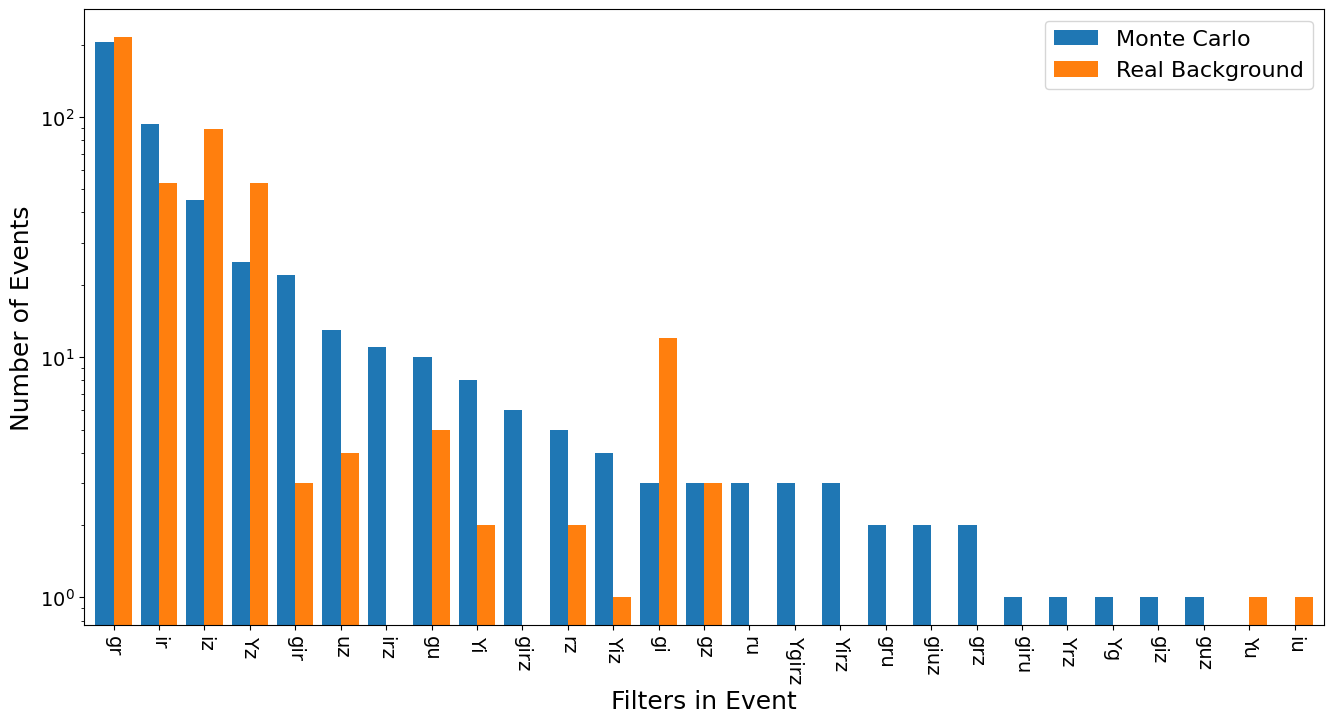

In [4]:
fig, ax = plt.subplots(figsize=(16, 8))
filter_seq_hist_df.plot.bar(ax=ax, width=0.8)
ax.set_yscale("log")
ax.set_xlabel("Filters in Event", fontsize=18)
ax.set_ylabel("Number of Events", fontsize=18)
ax.tick_params(labelsize=14)
ax.tick_params(axis='x', rotation=-90)
ax.legend(loc="upper right", fontsize=16)
# fig.savefig(f"{fig_dir}filters_in_event_mc.png")
plt.show(fig)

In [5]:
ev_per_source = count_events_per_source(results_df)
n_per_source_hist = ev_per_source.value_counts()
n_per_source_hist.loc[0] = lc_class_df["lightcurve_class"].value_counts()["unimodal"]
n_per_source_hist.name = "Monte Carlo"

ev_per_source_irl = count_events_per_source(results_df_irl)
n_per_source_hist_irl = ev_per_source_irl.value_counts()
n_per_source_hist_irl.loc[0] = lc_class_df_irl["lightcurve_class"].value_counts()["unimodal"]
n_per_source_hist_irl.name = "Real Background"

ev_per_source_df = pd.concat([n_per_source_hist, n_per_source_hist_irl], axis=1)
ev_per_source_df.dropna(inplace=True)
ev_per_source_df.sort_index(inplace=True)

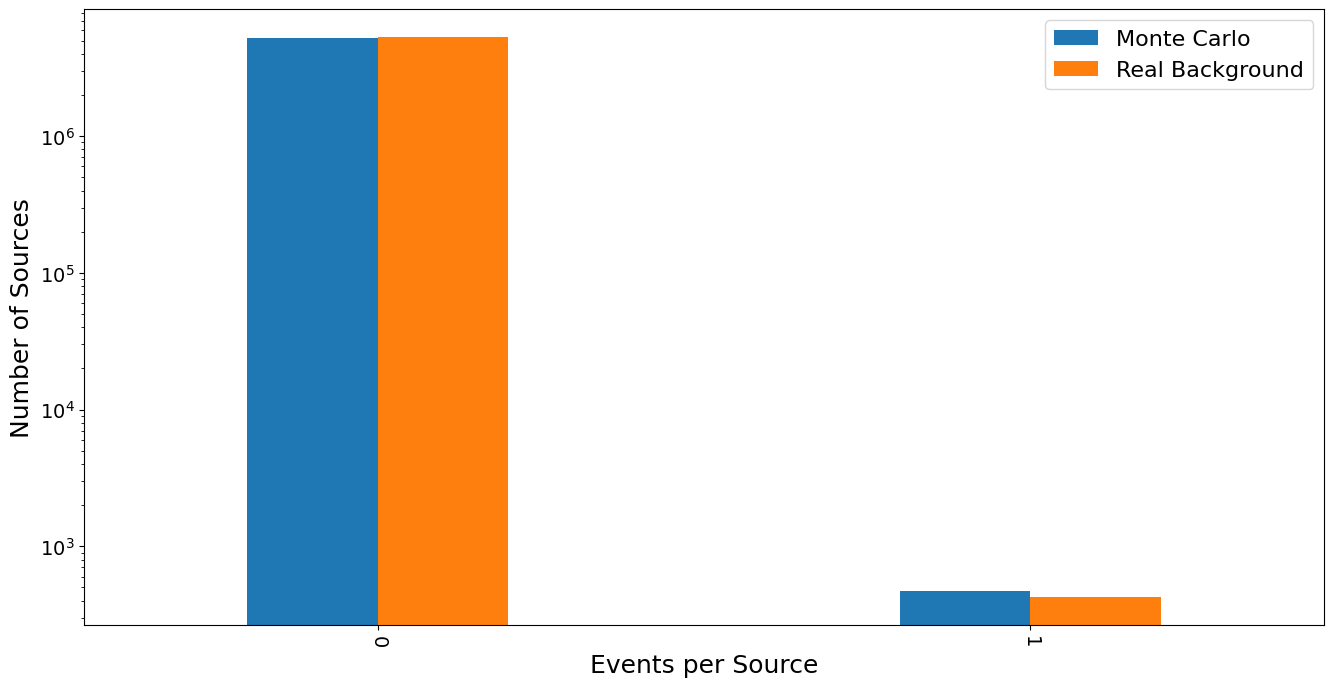

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
ev_per_source_df.plot.bar(ax=ax, width=0.4)
ax.set_yscale("log")
ax.set_xlabel("Events per Source", fontsize=18)
ax.set_ylabel("Number of Sources", fontsize=18)
ax.tick_params(labelsize=14)
ax.tick_params(axis='x', rotation=-90)
ax.legend(loc="upper right", fontsize=16)
# fig.savefig(f"{fig_dir}events_per_source_mc.png")
plt.show(fig)

In [7]:
taus = np.geomspace(1e-4, 1e4, num=50)
hist_counts = np.zeros((2, len(taus)))

dfs = [results_df, results_df_irl]

for j in range(len(dfs)):
    df = dfs[j]
    t_matrix = df[["t_start_max", "t_start_min", "t_end_min", "t_end_max"]].values

    for i in range(t_matrix.shape[0]):
        ts = t_matrix[i]
        post = integrated_event_duration_posterior(taus, ts)
        hist_counts[j] += post

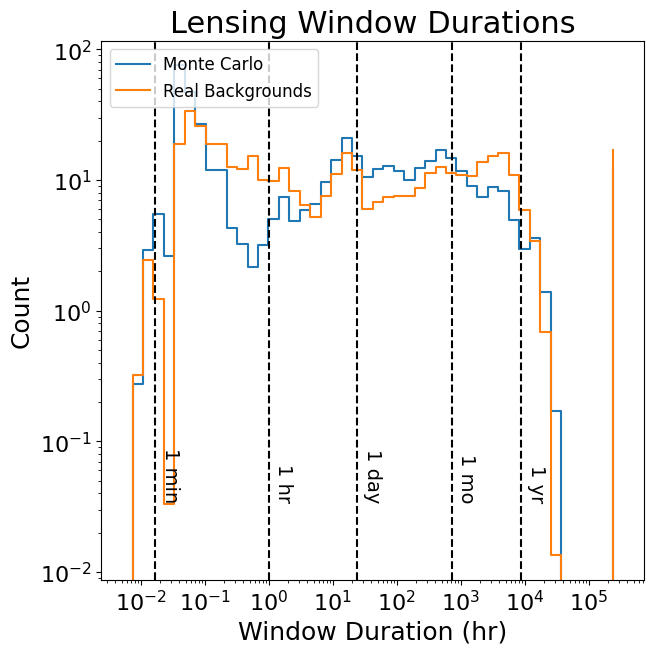

In [8]:
noteable_times = (np.array([60, 60 * 60, 60 * 60 * 24, 
                            60 * 60 * 24 * 30, 
                            60 * 60 * 24 * 365]) * (1 / 60**2))
time_labels = ["1 min", "1 hr", "1 day", "1 mo", "1 yr"]
x = taus * 24
labels = ["Monte Carlo", "Real Backgrounds"]

fig, ax = plt.subplots(figsize=(7, 7))

for i in range(len(labels)):
    h = hist_counts[i]
    label = labels[i]
    ax.plot(x, h, ds="steps-post", label=label)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Window Duration (hr)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Lensing Window Durations", fontsize=22)
ax.tick_params(labelsize=16)
ax.set_xlim((x[0], 3*x[-1]))
ax.legend(loc="upper left", fontsize=12)
blended_transform = ax.get_xaxis_transform()
axis_transform = ax.transAxes
axis_transform_inverse = axis_transform.inverted()

for t, l in zip(noteable_times, time_labels):
    ax.axvline(t, ls="--", color='k')
    (x, y) = axis_transform_inverse.transform(blended_transform.transform((t, 0.15)))
    ax.text(x+0.01, y, l, fontsize=14, transform=axis_transform, rotation=-90)

plt.show(fig)
# fig.savefig(f"{fig_dir}lensing_window_durations_mc.png")
plt.close(fig)

In [34]:
temp = lc_class_df.copy()
temp.index = temp["objectid"]
temp.drop(columns="objectid", inplace=True)

temp2 = rng_state.copy()
temp2.index = temp2["objectid"]
temp2.drop(columns="objectid", inplace=True)

In [37]:
df = pd.concat([temp, temp2], axis=1, join="inner")

In [44]:
def relens_lc(oid, rng_state):
    rng = np.random.default_rng(seed=

,lightcurve_class,rng_state
objectid,,
181390_3070,unimodal,189253017950692333228190946596444518037
181736_17807,unimodal,79209831345463646108553045025623522819
181391_136,unimodal,224136979101573525391354876381068359761
181391_141,unimodal,48938694425284826719431867996433362248
181736_18059,unimodal,288970186724486138824876096178450150336
...,...,...
192143_16960,unimodal,124411366643099887904539707848280608851
192143_2039,unimodal,114560676544872324699295109626654140261
192143_17113,unimodal,71406677015516137625136785558851824118


In [65]:
rng = np.random.default_rng(seed=12345)
state = rng.bit_generator.state
state

{'bit_generator': 'PCG64',
 'state': {'state': 33261208707367790463622745601869196757,
  'inc': 268209174141567072605526753992732310247},
 'has_uint32': 0,
 'uinteger': 0}

In [66]:
state.update({"state": {"state": 189253017950692333228190946596444518037, 
                        'inc': state["state"]["inc"]}})
state

{'bit_generator': 'PCG64',
 'state': {'state': 189253017950692333228190946596444518037,
  'inc': 268209174141567072605526753992732310247},
 'has_uint32': 0,
 'uinteger': 0}

In [67]:
rng.bit_generator.state = state
rng.uniform()

0.3644044887065435

In [68]:
rng.bit_generator.state = state
rng.uniform()

0.3644044887065435